# Práctica NLP Análisis de datos no estructurados.
- Guillermo Bécquer
- Luis Esgueva
- Ángel Romo

### Import Required Libraries

In [1]:
import os
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
print(tf.test.is_gpu_available())
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs: 1
True


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [5]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [6]:
MAX_NUM_SENTENCES = 25000

In [7]:
spa_eng = spa_eng[:MAX_NUM_SENTENCES,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [8]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I weigh 58 kilograms.', 'Peso 58 kilogramos.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1689840 (mookeee) & #1690643 (marcelostockle)'],
       ['I went into the army.', 'Me uní al ejército.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #262188 (CK) & #1781379 (marcelostockle)'],
       ['I went into the navy.', 'Me fui a la marina.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256592 (CK) & #5566661 (swyter)']],
      dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [9]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [10]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I weigh 58 kilograms', 'Peso 58 kilogramos',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1689840 (mookeee) & #1690643 (marcelostockle)'],
       ['I went into the army', 'Me uní al ejército',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #262188 (CK) & #1781379 (marcelostockle)'],
       ['I went into the navy', 'Me fui a la marina',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256592 (CK) & #5566661 (swyter)']],
      dtype='<U332')

In [11]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [12]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['i weigh 58 kilograms', 'peso 58 kilogramos',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1689840 (mookeee) & #1690643 (marcelostockle)'],
       ['i went into the army', 'me uní al ejército',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #262188 (CK) & #1781379 (marcelostockle)'],
       ['i went into the navy', 'me fui a la marina',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256592 (CK) & #5566661 (swyter)']],
      dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [13]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [14]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
24995    5    5
24996    4    4
24997    4    3
24998    5    4
24999    5    5

[25000 rows x 2 columns]
7
12


/home/aromo/anaconda3/envs/gpu/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


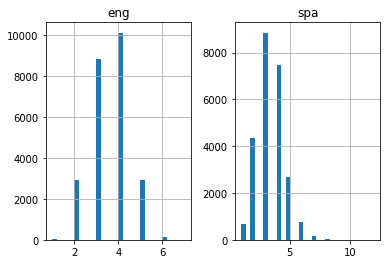

In [15]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4387


In [18]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Deutch Vocabulary Size: %d' % spa_vocab_size)

Deutch Vocabulary Size: 9132


In [19]:
print(spa_tokenizer.word_counts)

les', 1), ('diseñó', 1), ('contrario', 1), ('pesar', 1), ('cólera', 1), ('enriqueció', 1), ('agarró', 3), ('dama', 1), ('acababa', 2), ('redonda', 1), ('actuado', 1), ('picassos', 1), ('sostuvo', 1), ('pescadero', 1), ('grosera', 1), ('efectivamente', 1), ('penitencia', 1), ('80', 1), ('kilos', 1), ('soberbio', 1), ('dando', 4), ('lavando', 1), ('promesa', 1), ('quiénes', 3), ('sobria', 1), ('melón', 1), ('cardiff', 1), ('marruecos', 1), ('insecto', 1), ('haya', 4), ('masculló', 1), ('suele', 2), ('jaulas', 1), ('alcanzó', 3), ('administra', 1), ('zapatería', 1), ('lustró', 1), ('agradecerle', 2), ('cristianismo', 1), ('amarla', 1), ('amó', 2), ('ohio', 1), ('enterraron', 1), ('nombraron', 1), ('capitán', 2), ('terriblemente', 1), ('castigado', 2), ('derrotará', 1), ('aprobará', 1), ('dirá', 2), ('arrepentirá', 1), ('creerá', 1), ('laboratorio', 1), ('empeño', 1), ('rendir', 2), ('letra', 2), ('mejorará', 1), ('cazafantasmas', 1), ('guionista', 1), ('teme', 3), ('tantos', 1), ('centine

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

<bound method Tokenizer.texts_to_sequences of <keras_preprocessing.text.Tokenizer object at 0x000001D5AD17AA08>>


### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [22]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   7  224   36 ...    0    0    0]
 [  61  726    0 ...    0    0    0]
 [   3  175  182 ...    0    0    0]
 ...
 [  37  212 1066 ...    0    0    0]
 [ 135   49   75 ...    0    0    0]
 [   3  219 1430 ...    0    0    0]]
20000
[[   7  341   16 ...    0    0    0]
 [  29  591    0 ...    0    0    0]
 [   1  279  116 ...    0    0    0]
 ...
 [  29  538  256 ...    0    0    0]
 [ 223    3    2 ...    0    0    0]
 [   1  141 1294 ...    0    0    0]]
20000


In [23]:
print(trainX.shape)
print(trainY.shape)

(20000, 8)
(20000, 8)


In [24]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[1290 7690    0 ...    0    0    0]
 [ 756  791    0 ...    0    0    0]
 [3998    7  552 ...    0    0    0]
 ...
 [ 515  722    0 ...    0    0    0]
 [ 639   40 1746 ...    0    0    0]
 [  34    5  149 ...    7 4374    0]]
5000
[[ 150    1 1621 ...    0    0    0]
 [  13    3   35 ...    0    0    0]
 [ 184  113    7 ...    0    0    0]
 ...
 [   4   71  483 ...    0    0    0]
 [ 319   26 1329 ...    0    0    0]
 [  40    4 2034 ...    0    0    0]]
5000


In [25]:
print(testX.shape)
print(testY.shape)

(5000, 8)
(5000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [26]:
# build LSTM model
def build_model_lstm(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [27]:
from tensorflow.keras.layers import SimpleRNN
# build RNN model
def build_model_rnn(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [28]:
from tensorflow.keras.layers import GRU
# build NMT model
def build_model_gru(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/   If you try to force these pieces of the encoder-decoder together, you get an error indicating that the output of the decoder is 2D and 3D input to the decoder is required.

We can solve this using a RepeatVector layer. This layer simply repeats the provided 2D input multiple times to create a 3D output.

The RepeatVector layer can be used like an adapter to fit the encoder and decoder parts of the network together. We can configure the RepeatVector to repeat the fixed length vector one time for each time step in the output sequence.



To summarize, the RepeatVector is used as an **adapter to fit the fixed-sized 2D output of the encoder to the differing length and 3D input expected by the decoder**. The TimeDistributed wrapper allows the same output layer to be reused for each element in the output sequence.                              


In [29]:
### DO NOT RUN IT (example of RepeatVector)
#model = Sequential()
#model.add(Dense(32, input_dim=32))
#### now: model.output_shape == (None, 32)
# note: `None` is the batch dimension
#model.add(RepeatVector(3))
# now: model.output_shape == (None, 3, 32)

In the above example, the RepeatVector layer repeats the incoming inputs a specific number of time. The shape of the input in the above example was ( 32 , ). But the output shape of the RepeatVector was ( 3 , 32 ), since the inputs were repeated 3 times.

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [30]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

9132
4387
8
8


In [31]:
model_lstm = build_model_lstm(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms_lstm = optimizers.RMSprop(lr=0.001)
model_lstm.compile(optimizer=rms_lstm, loss='sparse_categorical_crossentropy')

In [32]:
model_rnn = build_model_rnn(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms_rnn = optimizers.RMSprop(lr=0.001)
model_rnn.compile(optimizer=rms_rnn, loss='sparse_categorical_crossentropy')

In [33]:
model_gru = build_model_gru(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms_gru = optimizers.RMSprop(lr=0.001)
model_gru.compile(optimizer=rms_gru, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [34]:
def train_and_save(check_name, model_name, model):
    checkpointer = ModelCheckpoint(check_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    earlystopper = EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=6,
        verbose=1,
        mode="min",
        restore_best_weights=True,
    )

    history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
            epochs=30, batch_size=256, 
            validation_split = 0.2,
            callbacks=[checkpointer, earlystopper], verbose=1)

    model.save("models/{}".format(model_name))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train','validation'])
    plt.xlabel("epochs")
    plt.ylabel("val_loss")
    plt.savefig('{}/val_loss.png'.format(check_name))
    plt.show()

In [35]:
checks = ['model.h1.lstm', 'model.h1.rnn', 'model.h1.gru']
model_names = ["lstm.h5", "rnn.h5", "gru.h5"]
models = [model_lstm, model_rnn, model_gru]

In [ ]:
# Ejecución de LSTM
_check = checks[0]
_model_name = model_names[0]
_model = models[0]
train_and_save(check_name=_check, model_name=_model_name, model=_model)
%reset_selective -f "^history$"

In [ ]:
# Ejecución de RNN
_check = checks[1]
_model_name = model_names[1]
_model = models[1]
train_and_save(check_name=_check, model_name=_model_name, model=_model)
%reset_selective -f "^history$"

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
15616/16000 [============================>.] - ETA: 0s - loss: 3.2632
Epoch 00001: val_loss improved from inf to 2.70911, saving model to model.h1.gru
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model.h1.gru/assets
16000/16000 [==============================] - 17s 1ms/sample - loss: 3.2490 - val_loss: 2.7091
Epoch 2/30
15616/16000 [============================>.] - ETA: 0s - loss: 2.6108
Epoch 00002: val_loss improved from 2.70911 to 2.55978, saving model to model.h1.gru
INFO:tensorflow:Assets written to: model.h1.gru/assets
16000/16000 [==============================] - 12s 759us/sample - loss: 2.6080 - val_loss: 2.5598
Epoch 3/30
15872/16000 [============================>.] - ETA: 0s - loss: 2.3892
Epoch 00003: val_loss improved from 2.55978 to 2.37529, saving model to model.h1.gru
INFO:tensorflow:Assets written to: model.h1.gru/assets
16000/16000 [====

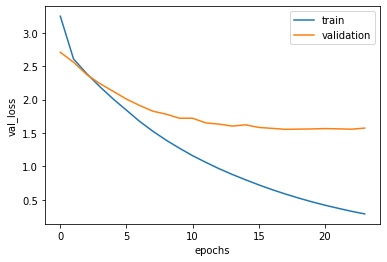

In [36]:
# Ejecución de GRU
_check = checks[2]
_model_name = model_names[2]
_model = models[2]
train_and_save(check_name=_check, model_name=_model_name, model=_model)
%reset_selective -f "^history$"

### Make Predictions

Let's load the saved model to make predictions.

In [37]:
loaded_model_lstm = load_model('lstm.h5')
preds_lstm = loaded_model_lstm.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [38]:
loaded_model_rnn = load_model('rnn.h5')
preds_rnn = loaded_model_rnn.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [39]:
loaded_model_gru = load_model('gru.h5')
preds_gru = loaded_model_gru.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [40]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [43]:
predictions = [preds_lstm, preds_rnn, preds_gru]
for model, preds in zip(model_names, predictions):
    print("-"*50)
    print("Haciendo predicciones para el modelo {}".format(model.split(".")[0]))
    preds_text = []
    for i in preds:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
                
            else:
                if(t == None):
                    temp.append('')
                else:
                    temp.append(t)            
            
        preds_text.append(' '.join(temp))

    pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
    pd.set_option('display.max_colwidth', 200)
    print("-"*50)
    print("Imprimiendo primeros 15 registros")
    print(pred_df.head(15))
    print("-"*50)
    print("Imprimiendo últimos 15 registros")
    print(pred_df.tail(15))
    print("-"*50)
    print("Imprimiendo 15 registros aleatorios")
    print(pred_df.sample(15))

--------------------------------------------------
Haciendo predicciones para el modelo lstm
--------------------------------------------------
Imprimiendo primeros 15 registros
                 actual                   predicted
0    should i repeat it         should i smoke     
1       do you know her               are you      
2   turn down the music         tell it dishes     
3          i hope i win           i hope to win    
4         thats evident          its is simple     
5         tom exercised          tom canceled      
6         call for help     help screamed help     
7          she loves us            she saw him     
8            i was last             i was face     
9   tom saved your life  tom misses your father    
10    this is so boring             this is so     
11  are you lying to me        are you lying me    
12  they lost their dog              they dog      
13      yours is better          the is better     
14    im as tall as tom            im am a